# Zeroth Pipeline

This pipeline compares zeroth order GD against standard GD. Three different zeroth order approximations --- one difference, two difference, and coordinate --- are tested.

### Imports

In [1]:
import os
import sys

p = os.path.abspath('../src/')
if p not in sys.path:
    sys.path.append(p)

In [2]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange

from difference_methods import one_point_estimate, two_point_estimate, coordinate_estimate
from linear_zeroth_function import Linear_Zeroth
from sigmoid_zeroth_function import Sigmoid_Zeroth
from relu_zeroth_function import ReLU_Zeroth

### Data preprocessing

In [3]:
proper_test = True # For testing the pipeline using iris instead of pendigits

if proper_test:
    data_train = data_train = pd.read_csv('../data/pendigits.csv')
else:
    data_train = pd.read_csv('../data/iris_train.csv')

print(data_train)

       input1  input2  input3  input4  input5  input6  input7  input8  input9  \
0          47     100      27      81      57      37      26       0       0   
1           0      89      27     100      42      75      29      45      15   
2           0      57      31      68      72      90     100     100      76   
3           0     100       7      92       5      68      19      45      86   
4           0      67      49      83     100     100      81      80      60   
...       ...     ...     ...     ...     ...     ...     ...     ...     ...   
10987      36     100      24      70       0      38      49      33      95   
10988      16      75      41     100      52      64      32      27       0   
10989      56     100      27      79       0      39      12       0      66   
10990      19     100       0      61       3      23      48       0      97   
10991      38     100      37      81      12      55       0      28      52   

       input10  input11  in

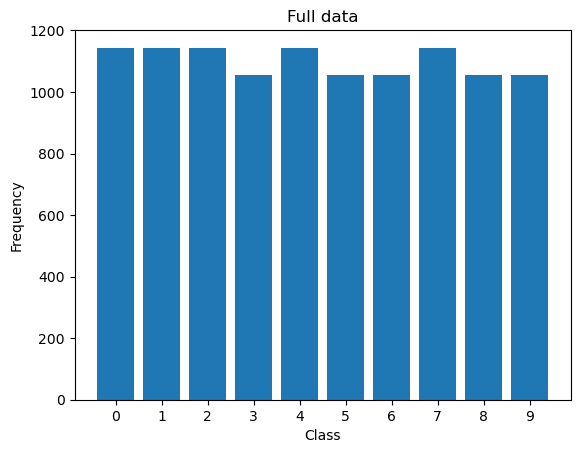

In [4]:
if proper_test:
    # extract frequency of each class
    class_freq = data_train['class'].value_counts()
else:
    # Convert string target values to numeric values
    #       class 0: Iris-setosa
    #       class 1: Iris-versicolor
    #       class 2: Iris-virginica
    data_train['species'] = data_train['species'].map({'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2})
    # also convert all string numeric values to float ['2' -> 2.0]
    data_train = data_train.apply(pd.to_numeric)
    # extract frequency of each species class
    class_freq = data_train['species'].value_counts()

class_freq = list(class_freq.sort_index())
nb_classes = len(class_freq)
nb_features = data_train.shape[1]-1

# Visual data
graph = plt.bar(list(range(nb_classes)), class_freq)
plt.xticks(list(range(nb_classes)))
plt.ylabel('Frequency')
plt.xlabel('Class')
plt.title('Full data')

plt.show() # balanced data set

In [5]:
# Preprocess data for training

# Convert pandas dataframe to array
data_train_array = data_train.values

# Split x (features) and y (targets)
x_array = data_train_array[:, :nb_features]
y_array = data_train_array[:, nb_features]

# Tensorify
X = torch.tensor(x_array, dtype=torch.float)
Y = torch.tensor(y_array, dtype=torch.long)

print(X.shape)

torch.Size([10992, 16])


### Network Setup

In [6]:
# INPUT/OUTPUT layer sizes
INPUT_NEURONS = nb_features
OUTPUT_NEURONS = nb_classes

In [7]:
# Hyperparameters
hidden_neurons_range = list(range(min(INPUT_NEURONS, OUTPUT_NEURONS), max(INPUT_NEURONS, OUTPUT_NEURONS)+1, 6))
mu_range = [1e-3, 1e-2, 1e-1]
n_range = list(range(1, min(INPUT_NEURONS, OUTPUT_NEURONS), 4))
difference_method_range = ['one','two','coord','sgd']

# Display hyperparameters:
print(f"Hidden Neuron Range: {hidden_neurons_range}")
print(f"Mu Range: {mu_range}")
print(f"N Range: {n_range}")
print(f"Descent Methods: {difference_method_range}")

Hidden Neuron Range: [10, 16]
Mu Range: [0.001, 0.01, 0.1]
N Range: [1, 5, 9]
Descent Methods: ['one', 'two', 'coord', 'sgd']


In [8]:
# Network architectures: 1 hidden layer

# Activation functions
# Normal network with sigmoid
def create_standard_sigmoid_network(hidden_neurons, mu, n, difference_method):
    torch.manual_seed(1) # so that same network init with same weights at each creation
    return torch.nn.Sequential(
        torch.nn.Linear(INPUT_NEURONS, hidden_neurons),
        torch.nn.Sigmoid(),
        torch.nn.Linear(hidden_neurons, OUTPUT_NEURONS)
    )

# Full Zeroth Order sigmoid
def create_zeroth_sigmoid_network(hidden_neurons, mu, n, difference_method):
    torch.manual_seed(1) # so that same network init with same weights at each creation
    return torch.nn.Sequential(
        Linear_Zeroth(INPUT_NEURONS, hidden_neurons, bias=False, difference_method=difference_method, mu=mu, n=n),
        Sigmoid_Zeroth(difference_method=difference_method, mu=mu, n=n),
        Linear_Zeroth(hidden_neurons, OUTPUT_NEURONS, bias=False, difference_method=difference_method, mu=mu, n=n)
)

# Normal network with relu
def create_standard_relu_network(hidden_neurons, mu, n, difference_method):
    torch.manual_seed(1) # so that same network init with same weights at each creation
    return torch.nn.Sequential(
        torch.nn.Linear(INPUT_NEURONS, hidden_neurons),
        torch.nn.ReLU(),
        torch.nn.Linear(hidden_neurons, OUTPUT_NEURONS)
    )

# Full Zeroth Order relu
def create_zeroth_relu_network(hidden_neurons, mu, n, difference_method):
    torch.manual_seed(1) # so that same network init with same weights at each creation
    return torch.nn.Sequential(
        Linear_Zeroth(INPUT_NEURONS, hidden_neurons, bias=False, difference_method=difference_method, mu=mu, n=n),
        ReLU_Zeroth(difference_method=difference_method, mu=mu, n=n),
        Linear_Zeroth(hidden_neurons, OUTPUT_NEURONS, bias=False, difference_method=difference_method, mu=mu, n=n),
)

std_network_funs = [
    ("standard_sigmoid", create_standard_sigmoid_network),
    ("standard_relu", create_standard_relu_network),
]

zero_network_funs = [
    ("zeroth_sigmoid", create_zeroth_sigmoid_network),
    ("zeroth_relu", create_zeroth_relu_network),
]


### Train and Plot Losses

In [9]:
# Training hyperparameters
# Training constants
LR = 0.01
NUM_EPOCH = 250
BATCH_SIZE = 64

# Loss function
loss_func = torch.nn.CrossEntropyLoss()

In [10]:
# Plot or save? False => Save
plot = False
path = "plots/"

In [11]:
# Train each network and plot the loss:
for net_idx, network in enumerate(zero_network_funs):
    name, network_fun = network
    for hidden_neurons in hidden_neurons_range:
        for mu in mu_range:
            for n in n_range:
                print(f"Network: {name}, Hidden neurons: {hidden_neurons}, Mu: {mu}, N: {n} \n=========")
                for diff_method in tqdm(difference_method_range, desc="method", leave=False, position=0):
                    plt.figure()
                    # Create new instance of network
                    if diff_method == "sgd":
                        network_fun = std_network_funs[net_idx][1]
                    network = network_fun(hidden_neurons, mu, n, diff_method)

                    # Optimiser
                    optimiser = torch.optim.SGD(network.parameters(), lr=LR)

                    # store all losses for visualisation
                    all_losses = []

                    # train a neural network
                    num_batches = len(X) // BATCH_SIZE
                    for epoch in tqdm(range(NUM_EPOCH), desc="epoch", leave=False, position=1):
                        epoch_loss = 0.0
                        for batch in range(num_batches):
                            # Get batch data
                            batch_start = batch * BATCH_SIZE
                            batch_end = (batch + 1) * BATCH_SIZE
                            batch_X = X[batch_start:batch_end]
                            batch_Y = Y[batch_start:batch_end]

                            # Perform forward pass
                            Y_pred = network(batch_X)
                            # Compute loss
                            loss = loss_func(Y_pred, batch_Y)
                            epoch_loss += loss.item()

                            # Clear the gradients before running the backward pass
                            network.zero_grad()
                            # Perform backward pass
                            loss.backward()
                            # Step optimiser
                            optimiser.step()

                        all_losses.append(epoch_loss / num_batches)

                        # Print progress
                        if epoch % 50 == 0:
                            # Convert three-column predicted Y values to one column for comparison
                            _, predicted = torch.max(torch.nn.functional.softmax(Y_pred, 1), 1)
                            # Calculate and print accuracy
                            total = predicted.size(0)
                            correct = predicted.data.numpy() == batch_Y.data.numpy()
                            # Print
                            print('Epoch [%d / %d] Loss: %.4f  Accuracy: %.2f %%'
                                  % (epoch + 1, NUM_EPOCH, epoch_loss / num_batches, 100 * sum(correct) / total))

                    # Plot
                    plt.plot(all_losses)

                    
                    plt.xlabel("Epoch")
                    plt.ylabel("Loss")
                    plt.legend(["One", "Two", "Coord", "SGD"])
                    if plot:
                        plt.show()
                    else:
                        plt.savefig(f"{path}{name}_hn{hidden_neurons}_mu{mu}_n{n}_{diff_method}.png")
                        plt.close()

Network: zeroth_sigmoid, Hidden neurons: 10, Mu: 0.001, N: 1 


method:   0%|          | 0/4 [00:00<?, ?it/s]

epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: nan  Accuracy: 1.56 %
Epoch [51 / 250] Loss: nan  Accuracy: 1.56 %
Epoch [101 / 250] Loss: nan  Accuracy: 1.56 %
Epoch [151 / 250] Loss: nan  Accuracy: 1.56 %
Epoch [201 / 250] Loss: nan  Accuracy: 1.56 %


epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 2.3501  Accuracy: 6.25 %
Epoch [51 / 250] Loss: 5.5499  Accuracy: 1.56 %
Epoch [101 / 250] Loss: 7.5394  Accuracy: 4.69 %
Epoch [151 / 250] Loss: 9.2909  Accuracy: 6.25 %
Epoch [201 / 250] Loss: 10.5250  Accuracy: 7.81 %


epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 2.3998  Accuracy: 10.94 %
Epoch [51 / 250] Loss: 2.7966  Accuracy: 1.56 %
Epoch [101 / 250] Loss: 7.1160  Accuracy: 1.56 %
Epoch [151 / 250] Loss: 14.2145  Accuracy: 1.56 %
Epoch [201 / 250] Loss: 21.0576  Accuracy: 1.56 %


epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 2.1725  Accuracy: 40.62 %
Epoch [51 / 250] Loss: 0.4971  Accuracy: 89.06 %
Epoch [101 / 250] Loss: 0.3899  Accuracy: 89.06 %
Epoch [151 / 250] Loss: 0.3291  Accuracy: 90.62 %
Epoch [201 / 250] Loss: 0.2925  Accuracy: 90.62 %
Network: zeroth_sigmoid, Hidden neurons: 10, Mu: 0.001, N: 5 


method:   0%|          | 0/4 [00:00<?, ?it/s]

epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 2.1725  Accuracy: 40.62 %
Epoch [51 / 250] Loss: 0.4971  Accuracy: 89.06 %
Epoch [101 / 250] Loss: 0.3899  Accuracy: 89.06 %
Epoch [151 / 250] Loss: 0.3291  Accuracy: 90.62 %
Epoch [201 / 250] Loss: 0.2925  Accuracy: 90.62 %


epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 2.1725  Accuracy: 40.62 %
Epoch [51 / 250] Loss: 0.4971  Accuracy: 89.06 %
Epoch [101 / 250] Loss: 0.3899  Accuracy: 89.06 %
Epoch [151 / 250] Loss: 0.3291  Accuracy: 90.62 %
Epoch [201 / 250] Loss: 0.2925  Accuracy: 90.62 %


epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 2.1725  Accuracy: 40.62 %
Epoch [51 / 250] Loss: 0.4971  Accuracy: 89.06 %
Epoch [101 / 250] Loss: 0.3899  Accuracy: 89.06 %
Epoch [151 / 250] Loss: 0.3291  Accuracy: 90.62 %
Epoch [201 / 250] Loss: 0.2925  Accuracy: 90.62 %


epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 2.1725  Accuracy: 40.62 %
Epoch [51 / 250] Loss: 0.4971  Accuracy: 89.06 %
Epoch [101 / 250] Loss: 0.3899  Accuracy: 89.06 %
Epoch [151 / 250] Loss: 0.3291  Accuracy: 90.62 %
Epoch [201 / 250] Loss: 0.2925  Accuracy: 90.62 %
Network: zeroth_sigmoid, Hidden neurons: 10, Mu: 0.001, N: 9 


method:   0%|          | 0/4 [00:00<?, ?it/s]

epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 2.1725  Accuracy: 40.62 %
Epoch [51 / 250] Loss: 0.4971  Accuracy: 89.06 %
Epoch [101 / 250] Loss: 0.3899  Accuracy: 89.06 %
Epoch [151 / 250] Loss: 0.3291  Accuracy: 90.62 %
Epoch [201 / 250] Loss: 0.2925  Accuracy: 90.62 %


epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 2.1725  Accuracy: 40.62 %
Epoch [51 / 250] Loss: 0.4971  Accuracy: 89.06 %
Epoch [101 / 250] Loss: 0.3899  Accuracy: 89.06 %
Epoch [151 / 250] Loss: 0.3291  Accuracy: 90.62 %
Epoch [201 / 250] Loss: 0.2925  Accuracy: 90.62 %


epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 2.1725  Accuracy: 40.62 %
Epoch [51 / 250] Loss: 0.4971  Accuracy: 89.06 %
Epoch [101 / 250] Loss: 0.3899  Accuracy: 89.06 %
Epoch [151 / 250] Loss: 0.3291  Accuracy: 90.62 %
Epoch [201 / 250] Loss: 0.2925  Accuracy: 90.62 %


epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 2.1725  Accuracy: 40.62 %
Epoch [51 / 250] Loss: 0.4971  Accuracy: 89.06 %
Epoch [101 / 250] Loss: 0.3899  Accuracy: 89.06 %
Epoch [151 / 250] Loss: 0.3291  Accuracy: 90.62 %
Epoch [201 / 250] Loss: 0.2925  Accuracy: 90.62 %
Network: zeroth_sigmoid, Hidden neurons: 10, Mu: 0.01, N: 1 


method:   0%|          | 0/4 [00:00<?, ?it/s]

epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 2.1725  Accuracy: 40.62 %
Epoch [51 / 250] Loss: 0.4971  Accuracy: 89.06 %
Epoch [101 / 250] Loss: 0.3899  Accuracy: 89.06 %
Epoch [151 / 250] Loss: 0.3291  Accuracy: 90.62 %
Epoch [201 / 250] Loss: 0.2925  Accuracy: 90.62 %


epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 2.1725  Accuracy: 40.62 %
Epoch [51 / 250] Loss: 0.4971  Accuracy: 89.06 %
Epoch [101 / 250] Loss: 0.3899  Accuracy: 89.06 %
Epoch [151 / 250] Loss: 0.3291  Accuracy: 90.62 %
Epoch [201 / 250] Loss: 0.2925  Accuracy: 90.62 %


epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 2.1725  Accuracy: 40.62 %
Epoch [51 / 250] Loss: 0.4971  Accuracy: 89.06 %
Epoch [101 / 250] Loss: 0.3899  Accuracy: 89.06 %
Epoch [151 / 250] Loss: 0.3291  Accuracy: 90.62 %
Epoch [201 / 250] Loss: 0.2925  Accuracy: 90.62 %


epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 2.1725  Accuracy: 40.62 %
Epoch [51 / 250] Loss: 0.4971  Accuracy: 89.06 %
Epoch [101 / 250] Loss: 0.3899  Accuracy: 89.06 %
Epoch [151 / 250] Loss: 0.3291  Accuracy: 90.62 %
Epoch [201 / 250] Loss: 0.2925  Accuracy: 90.62 %
Network: zeroth_sigmoid, Hidden neurons: 10, Mu: 0.01, N: 5 


method:   0%|          | 0/4 [00:00<?, ?it/s]

epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 2.1725  Accuracy: 40.62 %
Epoch [51 / 250] Loss: 0.4971  Accuracy: 89.06 %
Epoch [101 / 250] Loss: 0.3899  Accuracy: 89.06 %
Epoch [151 / 250] Loss: 0.3291  Accuracy: 90.62 %
Epoch [201 / 250] Loss: 0.2925  Accuracy: 90.62 %


epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 2.1725  Accuracy: 40.62 %
Epoch [51 / 250] Loss: 0.4971  Accuracy: 89.06 %
Epoch [101 / 250] Loss: 0.3899  Accuracy: 89.06 %
Epoch [151 / 250] Loss: 0.3291  Accuracy: 90.62 %
Epoch [201 / 250] Loss: 0.2925  Accuracy: 90.62 %


epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 2.1725  Accuracy: 40.62 %
Epoch [51 / 250] Loss: 0.4971  Accuracy: 89.06 %
Epoch [101 / 250] Loss: 0.3899  Accuracy: 89.06 %
Epoch [151 / 250] Loss: 0.3291  Accuracy: 90.62 %
Epoch [201 / 250] Loss: 0.2925  Accuracy: 90.62 %


epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 2.1725  Accuracy: 40.62 %
Epoch [51 / 250] Loss: 0.4971  Accuracy: 89.06 %
Epoch [101 / 250] Loss: 0.3899  Accuracy: 89.06 %
Epoch [151 / 250] Loss: 0.3291  Accuracy: 90.62 %
Epoch [201 / 250] Loss: 0.2925  Accuracy: 90.62 %
Network: zeroth_sigmoid, Hidden neurons: 10, Mu: 0.01, N: 9 


method:   0%|          | 0/4 [00:00<?, ?it/s]

epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 2.1725  Accuracy: 40.62 %
Epoch [51 / 250] Loss: 0.4971  Accuracy: 89.06 %
Epoch [101 / 250] Loss: 0.3899  Accuracy: 89.06 %
Epoch [151 / 250] Loss: 0.3291  Accuracy: 90.62 %
Epoch [201 / 250] Loss: 0.2925  Accuracy: 90.62 %


epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 2.1725  Accuracy: 40.62 %
Epoch [51 / 250] Loss: 0.4971  Accuracy: 89.06 %
Epoch [101 / 250] Loss: 0.3899  Accuracy: 89.06 %
Epoch [151 / 250] Loss: 0.3291  Accuracy: 90.62 %
Epoch [201 / 250] Loss: 0.2925  Accuracy: 90.62 %


epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 2.1725  Accuracy: 40.62 %
Epoch [51 / 250] Loss: 0.4971  Accuracy: 89.06 %
Epoch [101 / 250] Loss: 0.3899  Accuracy: 89.06 %
Epoch [151 / 250] Loss: 0.3291  Accuracy: 90.62 %
Epoch [201 / 250] Loss: 0.2925  Accuracy: 90.62 %


epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 2.1725  Accuracy: 40.62 %
Epoch [51 / 250] Loss: 0.4971  Accuracy: 89.06 %
Epoch [101 / 250] Loss: 0.3899  Accuracy: 89.06 %
Epoch [151 / 250] Loss: 0.3291  Accuracy: 90.62 %
Epoch [201 / 250] Loss: 0.2925  Accuracy: 90.62 %
Network: zeroth_sigmoid, Hidden neurons: 10, Mu: 0.1, N: 1 


method:   0%|          | 0/4 [00:00<?, ?it/s]

epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 2.1725  Accuracy: 40.62 %
Epoch [51 / 250] Loss: 0.4971  Accuracy: 89.06 %
Epoch [101 / 250] Loss: 0.3899  Accuracy: 89.06 %
Epoch [151 / 250] Loss: 0.3291  Accuracy: 90.62 %
Epoch [201 / 250] Loss: 0.2925  Accuracy: 90.62 %


epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 2.1725  Accuracy: 40.62 %
Epoch [51 / 250] Loss: 0.4971  Accuracy: 89.06 %
Epoch [101 / 250] Loss: 0.3899  Accuracy: 89.06 %
Epoch [151 / 250] Loss: 0.3291  Accuracy: 90.62 %
Epoch [201 / 250] Loss: 0.2925  Accuracy: 90.62 %


epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 2.1725  Accuracy: 40.62 %
Epoch [51 / 250] Loss: 0.4971  Accuracy: 89.06 %
Epoch [101 / 250] Loss: 0.3899  Accuracy: 89.06 %
Epoch [151 / 250] Loss: 0.3291  Accuracy: 90.62 %
Epoch [201 / 250] Loss: 0.2925  Accuracy: 90.62 %


epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 2.1725  Accuracy: 40.62 %
Epoch [51 / 250] Loss: 0.4971  Accuracy: 89.06 %
Epoch [101 / 250] Loss: 0.3899  Accuracy: 89.06 %
Epoch [151 / 250] Loss: 0.3291  Accuracy: 90.62 %
Epoch [201 / 250] Loss: 0.2925  Accuracy: 90.62 %
Network: zeroth_sigmoid, Hidden neurons: 10, Mu: 0.1, N: 5 


method:   0%|          | 0/4 [00:00<?, ?it/s]

epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 2.1725  Accuracy: 40.62 %
Epoch [51 / 250] Loss: 0.4971  Accuracy: 89.06 %
Epoch [101 / 250] Loss: 0.3899  Accuracy: 89.06 %
Epoch [151 / 250] Loss: 0.3291  Accuracy: 90.62 %
Epoch [201 / 250] Loss: 0.2925  Accuracy: 90.62 %


epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 2.1725  Accuracy: 40.62 %
Epoch [51 / 250] Loss: 0.4971  Accuracy: 89.06 %
Epoch [101 / 250] Loss: 0.3899  Accuracy: 89.06 %
Epoch [151 / 250] Loss: 0.3291  Accuracy: 90.62 %
Epoch [201 / 250] Loss: 0.2925  Accuracy: 90.62 %


epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 2.1725  Accuracy: 40.62 %
Epoch [51 / 250] Loss: 0.4971  Accuracy: 89.06 %
Epoch [101 / 250] Loss: 0.3899  Accuracy: 89.06 %
Epoch [151 / 250] Loss: 0.3291  Accuracy: 90.62 %
Epoch [201 / 250] Loss: 0.2925  Accuracy: 90.62 %


epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 2.1725  Accuracy: 40.62 %
Epoch [51 / 250] Loss: 0.4971  Accuracy: 89.06 %
Epoch [101 / 250] Loss: 0.3899  Accuracy: 89.06 %
Epoch [151 / 250] Loss: 0.3291  Accuracy: 90.62 %
Epoch [201 / 250] Loss: 0.2925  Accuracy: 90.62 %
Network: zeroth_sigmoid, Hidden neurons: 10, Mu: 0.1, N: 9 


method:   0%|          | 0/4 [00:00<?, ?it/s]

epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 2.1725  Accuracy: 40.62 %
Epoch [51 / 250] Loss: 0.4971  Accuracy: 89.06 %
Epoch [101 / 250] Loss: 0.3899  Accuracy: 89.06 %
Epoch [151 / 250] Loss: 0.3291  Accuracy: 90.62 %
Epoch [201 / 250] Loss: 0.2925  Accuracy: 90.62 %


epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 2.1725  Accuracy: 40.62 %
Epoch [51 / 250] Loss: 0.4971  Accuracy: 89.06 %
Epoch [101 / 250] Loss: 0.3899  Accuracy: 89.06 %
Epoch [151 / 250] Loss: 0.3291  Accuracy: 90.62 %
Epoch [201 / 250] Loss: 0.2925  Accuracy: 90.62 %


epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 2.1725  Accuracy: 40.62 %
Epoch [51 / 250] Loss: 0.4971  Accuracy: 89.06 %
Epoch [101 / 250] Loss: 0.3899  Accuracy: 89.06 %
Epoch [151 / 250] Loss: 0.3291  Accuracy: 90.62 %
Epoch [201 / 250] Loss: 0.2925  Accuracy: 90.62 %


epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 2.1725  Accuracy: 40.62 %
Epoch [51 / 250] Loss: 0.4971  Accuracy: 89.06 %
Epoch [101 / 250] Loss: 0.3899  Accuracy: 89.06 %
Epoch [151 / 250] Loss: 0.3291  Accuracy: 90.62 %
Epoch [201 / 250] Loss: 0.2925  Accuracy: 90.62 %
Network: zeroth_sigmoid, Hidden neurons: 16, Mu: 0.001, N: 1 


method:   0%|          | 0/4 [00:00<?, ?it/s]

epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 2.2174  Accuracy: 43.75 %
Epoch [51 / 250] Loss: 0.3260  Accuracy: 93.75 %
Epoch [101 / 250] Loss: 0.2044  Accuracy: 98.44 %
Epoch [151 / 250] Loss: 0.1648  Accuracy: 96.88 %
Epoch [201 / 250] Loss: 0.1481  Accuracy: 96.88 %


epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 2.2174  Accuracy: 43.75 %
Epoch [51 / 250] Loss: 0.3260  Accuracy: 93.75 %
Epoch [101 / 250] Loss: 0.2044  Accuracy: 98.44 %
Epoch [151 / 250] Loss: 0.1648  Accuracy: 96.88 %
Epoch [201 / 250] Loss: 0.1481  Accuracy: 96.88 %


epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 2.2174  Accuracy: 43.75 %
Epoch [51 / 250] Loss: 0.3260  Accuracy: 93.75 %
Epoch [101 / 250] Loss: 0.2044  Accuracy: 98.44 %
Epoch [151 / 250] Loss: 0.1648  Accuracy: 96.88 %
Epoch [201 / 250] Loss: 0.1481  Accuracy: 96.88 %


epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 2.2174  Accuracy: 43.75 %
Epoch [51 / 250] Loss: 0.3260  Accuracy: 93.75 %
Epoch [101 / 250] Loss: 0.2044  Accuracy: 98.44 %
Epoch [151 / 250] Loss: 0.1648  Accuracy: 96.88 %
Epoch [201 / 250] Loss: 0.1481  Accuracy: 96.88 %
Network: zeroth_sigmoid, Hidden neurons: 16, Mu: 0.001, N: 5 


method:   0%|          | 0/4 [00:00<?, ?it/s]

epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 2.2174  Accuracy: 43.75 %
Epoch [51 / 250] Loss: 0.3260  Accuracy: 93.75 %
Epoch [101 / 250] Loss: 0.2044  Accuracy: 98.44 %
Epoch [151 / 250] Loss: 0.1648  Accuracy: 96.88 %
Epoch [201 / 250] Loss: 0.1481  Accuracy: 96.88 %


epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 2.2174  Accuracy: 43.75 %
Epoch [51 / 250] Loss: 0.3260  Accuracy: 93.75 %
Epoch [101 / 250] Loss: 0.2044  Accuracy: 98.44 %
Epoch [151 / 250] Loss: 0.1648  Accuracy: 96.88 %
Epoch [201 / 250] Loss: 0.1481  Accuracy: 96.88 %


epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 2.2174  Accuracy: 43.75 %
Epoch [51 / 250] Loss: 0.3260  Accuracy: 93.75 %
Epoch [101 / 250] Loss: 0.2044  Accuracy: 98.44 %
Epoch [151 / 250] Loss: 0.1648  Accuracy: 96.88 %
Epoch [201 / 250] Loss: 0.1481  Accuracy: 96.88 %


epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 2.2174  Accuracy: 43.75 %
Epoch [51 / 250] Loss: 0.3260  Accuracy: 93.75 %
Epoch [101 / 250] Loss: 0.2044  Accuracy: 98.44 %
Epoch [151 / 250] Loss: 0.1648  Accuracy: 96.88 %
Epoch [201 / 250] Loss: 0.1481  Accuracy: 96.88 %
Network: zeroth_sigmoid, Hidden neurons: 16, Mu: 0.001, N: 9 


method:   0%|          | 0/4 [00:00<?, ?it/s]

epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 2.2174  Accuracy: 43.75 %
Epoch [51 / 250] Loss: 0.3260  Accuracy: 93.75 %
Epoch [101 / 250] Loss: 0.2044  Accuracy: 98.44 %
Epoch [151 / 250] Loss: 0.1648  Accuracy: 96.88 %
Epoch [201 / 250] Loss: 0.1481  Accuracy: 96.88 %


epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 2.2174  Accuracy: 43.75 %
Epoch [51 / 250] Loss: 0.3260  Accuracy: 93.75 %
Epoch [101 / 250] Loss: 0.2044  Accuracy: 98.44 %
Epoch [151 / 250] Loss: 0.1648  Accuracy: 96.88 %
Epoch [201 / 250] Loss: 0.1481  Accuracy: 96.88 %


epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 2.2174  Accuracy: 43.75 %
Epoch [51 / 250] Loss: 0.3260  Accuracy: 93.75 %
Epoch [101 / 250] Loss: 0.2044  Accuracy: 98.44 %
Epoch [151 / 250] Loss: 0.1648  Accuracy: 96.88 %
Epoch [201 / 250] Loss: 0.1481  Accuracy: 96.88 %


epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 2.2174  Accuracy: 43.75 %
Epoch [51 / 250] Loss: 0.3260  Accuracy: 93.75 %
Epoch [101 / 250] Loss: 0.2044  Accuracy: 98.44 %
Epoch [151 / 250] Loss: 0.1648  Accuracy: 96.88 %
Epoch [201 / 250] Loss: 0.1481  Accuracy: 96.88 %
Network: zeroth_sigmoid, Hidden neurons: 16, Mu: 0.01, N: 1 


method:   0%|          | 0/4 [00:00<?, ?it/s]

epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 2.2174  Accuracy: 43.75 %
Epoch [51 / 250] Loss: 0.3260  Accuracy: 93.75 %
Epoch [101 / 250] Loss: 0.2044  Accuracy: 98.44 %
Epoch [151 / 250] Loss: 0.1648  Accuracy: 96.88 %
Epoch [201 / 250] Loss: 0.1481  Accuracy: 96.88 %


epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 2.2174  Accuracy: 43.75 %
Epoch [51 / 250] Loss: 0.3260  Accuracy: 93.75 %
Epoch [101 / 250] Loss: 0.2044  Accuracy: 98.44 %
Epoch [151 / 250] Loss: 0.1648  Accuracy: 96.88 %
Epoch [201 / 250] Loss: 0.1481  Accuracy: 96.88 %


epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 2.2174  Accuracy: 43.75 %
Epoch [51 / 250] Loss: 0.3260  Accuracy: 93.75 %
Epoch [101 / 250] Loss: 0.2044  Accuracy: 98.44 %
Epoch [151 / 250] Loss: 0.1648  Accuracy: 96.88 %
Epoch [201 / 250] Loss: 0.1481  Accuracy: 96.88 %


epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 2.2174  Accuracy: 43.75 %
Epoch [51 / 250] Loss: 0.3260  Accuracy: 93.75 %
Epoch [101 / 250] Loss: 0.2044  Accuracy: 98.44 %
Epoch [151 / 250] Loss: 0.1648  Accuracy: 96.88 %
Epoch [201 / 250] Loss: 0.1481  Accuracy: 96.88 %
Network: zeroth_sigmoid, Hidden neurons: 16, Mu: 0.01, N: 5 


method:   0%|          | 0/4 [00:00<?, ?it/s]

epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 2.2174  Accuracy: 43.75 %
Epoch [51 / 250] Loss: 0.3260  Accuracy: 93.75 %
Epoch [101 / 250] Loss: 0.2044  Accuracy: 98.44 %
Epoch [151 / 250] Loss: 0.1648  Accuracy: 96.88 %
Epoch [201 / 250] Loss: 0.1481  Accuracy: 96.88 %


epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 2.2174  Accuracy: 43.75 %
Epoch [51 / 250] Loss: 0.3260  Accuracy: 93.75 %
Epoch [101 / 250] Loss: 0.2044  Accuracy: 98.44 %
Epoch [151 / 250] Loss: 0.1648  Accuracy: 96.88 %
Epoch [201 / 250] Loss: 0.1481  Accuracy: 96.88 %


epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 2.2174  Accuracy: 43.75 %
Epoch [51 / 250] Loss: 0.3260  Accuracy: 93.75 %
Epoch [101 / 250] Loss: 0.2044  Accuracy: 98.44 %
Epoch [151 / 250] Loss: 0.1648  Accuracy: 96.88 %
Epoch [201 / 250] Loss: 0.1481  Accuracy: 96.88 %


epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 2.2174  Accuracy: 43.75 %
Epoch [51 / 250] Loss: 0.3260  Accuracy: 93.75 %
Epoch [101 / 250] Loss: 0.2044  Accuracy: 98.44 %
Epoch [151 / 250] Loss: 0.1648  Accuracy: 96.88 %
Epoch [201 / 250] Loss: 0.1481  Accuracy: 96.88 %
Network: zeroth_sigmoid, Hidden neurons: 16, Mu: 0.01, N: 9 


method:   0%|          | 0/4 [00:00<?, ?it/s]

epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 2.2174  Accuracy: 43.75 %
Epoch [51 / 250] Loss: 0.3260  Accuracy: 93.75 %
Epoch [101 / 250] Loss: 0.2044  Accuracy: 98.44 %
Epoch [151 / 250] Loss: 0.1648  Accuracy: 96.88 %
Epoch [201 / 250] Loss: 0.1481  Accuracy: 96.88 %


epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 2.2174  Accuracy: 43.75 %
Epoch [51 / 250] Loss: 0.3260  Accuracy: 93.75 %
Epoch [101 / 250] Loss: 0.2044  Accuracy: 98.44 %
Epoch [151 / 250] Loss: 0.1648  Accuracy: 96.88 %
Epoch [201 / 250] Loss: 0.1481  Accuracy: 96.88 %


epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 2.2174  Accuracy: 43.75 %
Epoch [51 / 250] Loss: 0.3260  Accuracy: 93.75 %
Epoch [101 / 250] Loss: 0.2044  Accuracy: 98.44 %
Epoch [151 / 250] Loss: 0.1648  Accuracy: 96.88 %
Epoch [201 / 250] Loss: 0.1481  Accuracy: 96.88 %


epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 2.2174  Accuracy: 43.75 %
Epoch [51 / 250] Loss: 0.3260  Accuracy: 93.75 %
Epoch [101 / 250] Loss: 0.2044  Accuracy: 98.44 %
Epoch [151 / 250] Loss: 0.1648  Accuracy: 96.88 %
Epoch [201 / 250] Loss: 0.1481  Accuracy: 96.88 %
Network: zeroth_sigmoid, Hidden neurons: 16, Mu: 0.1, N: 1 


method:   0%|          | 0/4 [00:00<?, ?it/s]

epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 2.2174  Accuracy: 43.75 %
Epoch [51 / 250] Loss: 0.3260  Accuracy: 93.75 %
Epoch [101 / 250] Loss: 0.2044  Accuracy: 98.44 %
Epoch [151 / 250] Loss: 0.1648  Accuracy: 96.88 %
Epoch [201 / 250] Loss: 0.1481  Accuracy: 96.88 %


epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 2.2174  Accuracy: 43.75 %
Epoch [51 / 250] Loss: 0.3260  Accuracy: 93.75 %
Epoch [101 / 250] Loss: 0.2044  Accuracy: 98.44 %
Epoch [151 / 250] Loss: 0.1648  Accuracy: 96.88 %
Epoch [201 / 250] Loss: 0.1481  Accuracy: 96.88 %


epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 2.2174  Accuracy: 43.75 %
Epoch [51 / 250] Loss: 0.3260  Accuracy: 93.75 %
Epoch [101 / 250] Loss: 0.2044  Accuracy: 98.44 %
Epoch [151 / 250] Loss: 0.1648  Accuracy: 96.88 %
Epoch [201 / 250] Loss: 0.1481  Accuracy: 96.88 %


epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 2.2174  Accuracy: 43.75 %
Epoch [51 / 250] Loss: 0.3260  Accuracy: 93.75 %
Epoch [101 / 250] Loss: 0.2044  Accuracy: 98.44 %
Epoch [151 / 250] Loss: 0.1648  Accuracy: 96.88 %
Epoch [201 / 250] Loss: 0.1481  Accuracy: 96.88 %
Network: zeroth_sigmoid, Hidden neurons: 16, Mu: 0.1, N: 5 


method:   0%|          | 0/4 [00:00<?, ?it/s]

epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 2.2174  Accuracy: 43.75 %
Epoch [51 / 250] Loss: 0.3260  Accuracy: 93.75 %
Epoch [101 / 250] Loss: 0.2044  Accuracy: 98.44 %
Epoch [151 / 250] Loss: 0.1648  Accuracy: 96.88 %
Epoch [201 / 250] Loss: 0.1481  Accuracy: 96.88 %


epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 2.2174  Accuracy: 43.75 %
Epoch [51 / 250] Loss: 0.3260  Accuracy: 93.75 %
Epoch [101 / 250] Loss: 0.2044  Accuracy: 98.44 %
Epoch [151 / 250] Loss: 0.1648  Accuracy: 96.88 %
Epoch [201 / 250] Loss: 0.1481  Accuracy: 96.88 %


epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 2.2174  Accuracy: 43.75 %
Epoch [51 / 250] Loss: 0.3260  Accuracy: 93.75 %
Epoch [101 / 250] Loss: 0.2044  Accuracy: 98.44 %
Epoch [151 / 250] Loss: 0.1648  Accuracy: 96.88 %
Epoch [201 / 250] Loss: 0.1481  Accuracy: 96.88 %


epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 2.2174  Accuracy: 43.75 %
Epoch [51 / 250] Loss: 0.3260  Accuracy: 93.75 %
Epoch [101 / 250] Loss: 0.2044  Accuracy: 98.44 %
Epoch [151 / 250] Loss: 0.1648  Accuracy: 96.88 %
Epoch [201 / 250] Loss: 0.1481  Accuracy: 96.88 %
Network: zeroth_sigmoid, Hidden neurons: 16, Mu: 0.1, N: 9 


method:   0%|          | 0/4 [00:00<?, ?it/s]

epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 2.2174  Accuracy: 43.75 %
Epoch [51 / 250] Loss: 0.3260  Accuracy: 93.75 %
Epoch [101 / 250] Loss: 0.2044  Accuracy: 98.44 %
Epoch [151 / 250] Loss: 0.1648  Accuracy: 96.88 %
Epoch [201 / 250] Loss: 0.1481  Accuracy: 96.88 %


epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 2.2174  Accuracy: 43.75 %
Epoch [51 / 250] Loss: 0.3260  Accuracy: 93.75 %
Epoch [101 / 250] Loss: 0.2044  Accuracy: 98.44 %
Epoch [151 / 250] Loss: 0.1648  Accuracy: 96.88 %
Epoch [201 / 250] Loss: 0.1481  Accuracy: 96.88 %


epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 2.2174  Accuracy: 43.75 %
Epoch [51 / 250] Loss: 0.3260  Accuracy: 93.75 %
Epoch [101 / 250] Loss: 0.2044  Accuracy: 98.44 %
Epoch [151 / 250] Loss: 0.1648  Accuracy: 96.88 %
Epoch [201 / 250] Loss: 0.1481  Accuracy: 96.88 %


epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 2.2174  Accuracy: 43.75 %
Epoch [51 / 250] Loss: 0.3260  Accuracy: 93.75 %
Epoch [101 / 250] Loss: 0.2044  Accuracy: 98.44 %
Epoch [151 / 250] Loss: 0.1648  Accuracy: 96.88 %
Epoch [201 / 250] Loss: 0.1481  Accuracy: 96.88 %
Network: zeroth_relu, Hidden neurons: 10, Mu: 0.001, N: 1 


method:   0%|          | 0/4 [00:00<?, ?it/s]

epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: nan  Accuracy: 1.56 %
Epoch [51 / 250] Loss: nan  Accuracy: 1.56 %
Epoch [101 / 250] Loss: nan  Accuracy: 1.56 %
Epoch [151 / 250] Loss: nan  Accuracy: 1.56 %
Epoch [201 / 250] Loss: nan  Accuracy: 1.56 %


epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 1053432816054214.3750  Accuracy: 4.69 %
Epoch [51 / 250] Loss: 1072687181908123.7500  Accuracy: 4.69 %
Epoch [101 / 250] Loss: 1072687181908123.7500  Accuracy: 4.69 %
Epoch [151 / 250] Loss: 1072687181908123.7500  Accuracy: 4.69 %
Epoch [201 / 250] Loss: 1072687181908123.7500  Accuracy: 4.69 %


epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 23.3246  Accuracy: 17.19 %
Epoch [51 / 250] Loss: 909369223232865.2500  Accuracy: 17.19 %
Epoch [101 / 250] Loss: 909369223232865.2500  Accuracy: 17.19 %
Epoch [151 / 250] Loss: 909369223232865.2500  Accuracy: 17.19 %
Epoch [201 / 250] Loss: 909369223232865.2500  Accuracy: 17.19 %


epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 1.7406  Accuracy: 53.12 %
Epoch [51 / 250] Loss: 0.3625  Accuracy: 90.62 %
Epoch [101 / 250] Loss: 0.3294  Accuracy: 90.62 %
Epoch [151 / 250] Loss: 0.3167  Accuracy: 93.75 %
Epoch [201 / 250] Loss: 0.3098  Accuracy: 90.62 %
Network: zeroth_relu, Hidden neurons: 10, Mu: 0.001, N: 5 


method:   0%|          | 0/4 [00:00<?, ?it/s]

epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 1.7406  Accuracy: 53.12 %
Epoch [51 / 250] Loss: 0.3625  Accuracy: 90.62 %
Epoch [101 / 250] Loss: 0.3294  Accuracy: 90.62 %
Epoch [151 / 250] Loss: 0.3167  Accuracy: 93.75 %
Epoch [201 / 250] Loss: 0.3098  Accuracy: 90.62 %


epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 1.7406  Accuracy: 53.12 %
Epoch [51 / 250] Loss: 0.3625  Accuracy: 90.62 %
Epoch [101 / 250] Loss: 0.3294  Accuracy: 90.62 %
Epoch [151 / 250] Loss: 0.3167  Accuracy: 93.75 %
Epoch [201 / 250] Loss: 0.3098  Accuracy: 90.62 %


epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 1.7406  Accuracy: 53.12 %
Epoch [51 / 250] Loss: 0.3625  Accuracy: 90.62 %
Epoch [101 / 250] Loss: 0.3294  Accuracy: 90.62 %
Epoch [151 / 250] Loss: 0.3167  Accuracy: 93.75 %
Epoch [201 / 250] Loss: 0.3098  Accuracy: 90.62 %


epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 1.7406  Accuracy: 53.12 %
Epoch [51 / 250] Loss: 0.3625  Accuracy: 90.62 %
Epoch [101 / 250] Loss: 0.3294  Accuracy: 90.62 %
Epoch [151 / 250] Loss: 0.3167  Accuracy: 93.75 %
Epoch [201 / 250] Loss: 0.3098  Accuracy: 90.62 %
Network: zeroth_relu, Hidden neurons: 10, Mu: 0.001, N: 9 


method:   0%|          | 0/4 [00:00<?, ?it/s]

epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 1.7406  Accuracy: 53.12 %
Epoch [51 / 250] Loss: 0.3625  Accuracy: 90.62 %
Epoch [101 / 250] Loss: 0.3294  Accuracy: 90.62 %
Epoch [151 / 250] Loss: 0.3167  Accuracy: 93.75 %
Epoch [201 / 250] Loss: 0.3098  Accuracy: 90.62 %


epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 1.7406  Accuracy: 53.12 %
Epoch [51 / 250] Loss: 0.3625  Accuracy: 90.62 %
Epoch [101 / 250] Loss: 0.3294  Accuracy: 90.62 %
Epoch [151 / 250] Loss: 0.3167  Accuracy: 93.75 %
Epoch [201 / 250] Loss: 0.3098  Accuracy: 90.62 %


epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 1.7406  Accuracy: 53.12 %
Epoch [51 / 250] Loss: 0.3625  Accuracy: 90.62 %
Epoch [101 / 250] Loss: 0.3294  Accuracy: 90.62 %
Epoch [151 / 250] Loss: 0.3167  Accuracy: 93.75 %
Epoch [201 / 250] Loss: 0.3098  Accuracy: 90.62 %


epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 1.7406  Accuracy: 53.12 %
Epoch [51 / 250] Loss: 0.3625  Accuracy: 90.62 %
Epoch [101 / 250] Loss: 0.3294  Accuracy: 90.62 %
Epoch [151 / 250] Loss: 0.3167  Accuracy: 93.75 %
Epoch [201 / 250] Loss: 0.3098  Accuracy: 90.62 %
Network: zeroth_relu, Hidden neurons: 10, Mu: 0.01, N: 1 


method:   0%|          | 0/4 [00:00<?, ?it/s]

epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 1.7406  Accuracy: 53.12 %
Epoch [51 / 250] Loss: 0.3625  Accuracy: 90.62 %
Epoch [101 / 250] Loss: 0.3294  Accuracy: 90.62 %
Epoch [151 / 250] Loss: 0.3167  Accuracy: 93.75 %
Epoch [201 / 250] Loss: 0.3098  Accuracy: 90.62 %


epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 1.7406  Accuracy: 53.12 %
Epoch [51 / 250] Loss: 0.3625  Accuracy: 90.62 %
Epoch [101 / 250] Loss: 0.3294  Accuracy: 90.62 %
Epoch [151 / 250] Loss: 0.3167  Accuracy: 93.75 %
Epoch [201 / 250] Loss: 0.3098  Accuracy: 90.62 %


epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 1.7406  Accuracy: 53.12 %
Epoch [51 / 250] Loss: 0.3625  Accuracy: 90.62 %
Epoch [101 / 250] Loss: 0.3294  Accuracy: 90.62 %
Epoch [151 / 250] Loss: 0.3167  Accuracy: 93.75 %
Epoch [201 / 250] Loss: 0.3098  Accuracy: 90.62 %


epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 1.7406  Accuracy: 53.12 %
Epoch [51 / 250] Loss: 0.3625  Accuracy: 90.62 %
Epoch [101 / 250] Loss: 0.3294  Accuracy: 90.62 %
Epoch [151 / 250] Loss: 0.3167  Accuracy: 93.75 %
Epoch [201 / 250] Loss: 0.3098  Accuracy: 90.62 %
Network: zeroth_relu, Hidden neurons: 10, Mu: 0.01, N: 5 


method:   0%|          | 0/4 [00:00<?, ?it/s]

epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 1.7406  Accuracy: 53.12 %
Epoch [51 / 250] Loss: 0.3625  Accuracy: 90.62 %
Epoch [101 / 250] Loss: 0.3294  Accuracy: 90.62 %
Epoch [151 / 250] Loss: 0.3167  Accuracy: 93.75 %
Epoch [201 / 250] Loss: 0.3098  Accuracy: 90.62 %


epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 1.7406  Accuracy: 53.12 %
Epoch [51 / 250] Loss: 0.3625  Accuracy: 90.62 %
Epoch [101 / 250] Loss: 0.3294  Accuracy: 90.62 %
Epoch [151 / 250] Loss: 0.3167  Accuracy: 93.75 %
Epoch [201 / 250] Loss: 0.3098  Accuracy: 90.62 %


epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 1.7406  Accuracy: 53.12 %
Epoch [51 / 250] Loss: 0.3625  Accuracy: 90.62 %
Epoch [101 / 250] Loss: 0.3294  Accuracy: 90.62 %
Epoch [151 / 250] Loss: 0.3167  Accuracy: 93.75 %
Epoch [201 / 250] Loss: 0.3098  Accuracy: 90.62 %


epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 1.7406  Accuracy: 53.12 %
Epoch [51 / 250] Loss: 0.3625  Accuracy: 90.62 %
Epoch [101 / 250] Loss: 0.3294  Accuracy: 90.62 %
Epoch [151 / 250] Loss: 0.3167  Accuracy: 93.75 %
Epoch [201 / 250] Loss: 0.3098  Accuracy: 90.62 %
Network: zeroth_relu, Hidden neurons: 10, Mu: 0.01, N: 9 


method:   0%|          | 0/4 [00:00<?, ?it/s]

epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 1.7406  Accuracy: 53.12 %
Epoch [51 / 250] Loss: 0.3625  Accuracy: 90.62 %
Epoch [101 / 250] Loss: 0.3294  Accuracy: 90.62 %
Epoch [151 / 250] Loss: 0.3167  Accuracy: 93.75 %
Epoch [201 / 250] Loss: 0.3098  Accuracy: 90.62 %


epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 1.7406  Accuracy: 53.12 %
Epoch [51 / 250] Loss: 0.3625  Accuracy: 90.62 %
Epoch [101 / 250] Loss: 0.3294  Accuracy: 90.62 %
Epoch [151 / 250] Loss: 0.3167  Accuracy: 93.75 %
Epoch [201 / 250] Loss: 0.3098  Accuracy: 90.62 %


epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 1.7406  Accuracy: 53.12 %
Epoch [51 / 250] Loss: 0.3625  Accuracy: 90.62 %
Epoch [101 / 250] Loss: 0.3294  Accuracy: 90.62 %
Epoch [151 / 250] Loss: 0.3167  Accuracy: 93.75 %
Epoch [201 / 250] Loss: 0.3098  Accuracy: 90.62 %


epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 1.7406  Accuracy: 53.12 %
Epoch [51 / 250] Loss: 0.3625  Accuracy: 90.62 %
Epoch [101 / 250] Loss: 0.3294  Accuracy: 90.62 %
Epoch [151 / 250] Loss: 0.3167  Accuracy: 93.75 %
Epoch [201 / 250] Loss: 0.3098  Accuracy: 90.62 %
Network: zeroth_relu, Hidden neurons: 10, Mu: 0.1, N: 1 


method:   0%|          | 0/4 [00:00<?, ?it/s]

epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 1.7406  Accuracy: 53.12 %
Epoch [51 / 250] Loss: 0.3625  Accuracy: 90.62 %
Epoch [101 / 250] Loss: 0.3294  Accuracy: 90.62 %
Epoch [151 / 250] Loss: 0.3167  Accuracy: 93.75 %
Epoch [201 / 250] Loss: 0.3098  Accuracy: 90.62 %


epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 1.7406  Accuracy: 53.12 %
Epoch [51 / 250] Loss: 0.3625  Accuracy: 90.62 %
Epoch [101 / 250] Loss: 0.3294  Accuracy: 90.62 %
Epoch [151 / 250] Loss: 0.3167  Accuracy: 93.75 %
Epoch [201 / 250] Loss: 0.3098  Accuracy: 90.62 %


epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 1.7406  Accuracy: 53.12 %
Epoch [51 / 250] Loss: 0.3625  Accuracy: 90.62 %
Epoch [101 / 250] Loss: 0.3294  Accuracy: 90.62 %
Epoch [151 / 250] Loss: 0.3167  Accuracy: 93.75 %
Epoch [201 / 250] Loss: 0.3098  Accuracy: 90.62 %


epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 1.7406  Accuracy: 53.12 %
Epoch [51 / 250] Loss: 0.3625  Accuracy: 90.62 %
Epoch [101 / 250] Loss: 0.3294  Accuracy: 90.62 %
Epoch [151 / 250] Loss: 0.3167  Accuracy: 93.75 %
Epoch [201 / 250] Loss: 0.3098  Accuracy: 90.62 %
Network: zeroth_relu, Hidden neurons: 10, Mu: 0.1, N: 5 


method:   0%|          | 0/4 [00:00<?, ?it/s]

epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 1.7406  Accuracy: 53.12 %
Epoch [51 / 250] Loss: 0.3625  Accuracy: 90.62 %
Epoch [101 / 250] Loss: 0.3294  Accuracy: 90.62 %
Epoch [151 / 250] Loss: 0.3167  Accuracy: 93.75 %
Epoch [201 / 250] Loss: 0.3098  Accuracy: 90.62 %


epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 1.7406  Accuracy: 53.12 %
Epoch [51 / 250] Loss: 0.3625  Accuracy: 90.62 %
Epoch [101 / 250] Loss: 0.3294  Accuracy: 90.62 %
Epoch [151 / 250] Loss: 0.3167  Accuracy: 93.75 %
Epoch [201 / 250] Loss: 0.3098  Accuracy: 90.62 %


epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 1.7406  Accuracy: 53.12 %
Epoch [51 / 250] Loss: 0.3625  Accuracy: 90.62 %
Epoch [101 / 250] Loss: 0.3294  Accuracy: 90.62 %
Epoch [151 / 250] Loss: 0.3167  Accuracy: 93.75 %
Epoch [201 / 250] Loss: 0.3098  Accuracy: 90.62 %


epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 1.7406  Accuracy: 53.12 %
Epoch [51 / 250] Loss: 0.3625  Accuracy: 90.62 %
Epoch [101 / 250] Loss: 0.3294  Accuracy: 90.62 %
Epoch [151 / 250] Loss: 0.3167  Accuracy: 93.75 %
Epoch [201 / 250] Loss: 0.3098  Accuracy: 90.62 %
Network: zeroth_relu, Hidden neurons: 10, Mu: 0.1, N: 9 


method:   0%|          | 0/4 [00:00<?, ?it/s]

epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 1.7406  Accuracy: 53.12 %
Epoch [51 / 250] Loss: 0.3625  Accuracy: 90.62 %
Epoch [101 / 250] Loss: 0.3294  Accuracy: 90.62 %
Epoch [151 / 250] Loss: 0.3167  Accuracy: 93.75 %
Epoch [201 / 250] Loss: 0.3098  Accuracy: 90.62 %


epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 1.7406  Accuracy: 53.12 %
Epoch [51 / 250] Loss: 0.3625  Accuracy: 90.62 %
Epoch [101 / 250] Loss: 0.3294  Accuracy: 90.62 %
Epoch [151 / 250] Loss: 0.3167  Accuracy: 93.75 %
Epoch [201 / 250] Loss: 0.3098  Accuracy: 90.62 %


epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 1.7406  Accuracy: 53.12 %
Epoch [51 / 250] Loss: 0.3625  Accuracy: 90.62 %
Epoch [101 / 250] Loss: 0.3294  Accuracy: 90.62 %
Epoch [151 / 250] Loss: 0.3167  Accuracy: 93.75 %
Epoch [201 / 250] Loss: 0.3098  Accuracy: 90.62 %


epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 1.7406  Accuracy: 53.12 %
Epoch [51 / 250] Loss: 0.3625  Accuracy: 90.62 %
Epoch [101 / 250] Loss: 0.3294  Accuracy: 90.62 %
Epoch [151 / 250] Loss: 0.3167  Accuracy: 93.75 %
Epoch [201 / 250] Loss: 0.3098  Accuracy: 90.62 %
Network: zeroth_relu, Hidden neurons: 16, Mu: 0.001, N: 1 


method:   0%|          | 0/4 [00:00<?, ?it/s]

epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 1.8129  Accuracy: 54.69 %
Epoch [51 / 250] Loss: 0.1803  Accuracy: 96.88 %
Epoch [101 / 250] Loss: 0.1415  Accuracy: 100.00 %
Epoch [151 / 250] Loss: 0.1238  Accuracy: 100.00 %
Epoch [201 / 250] Loss: 0.1105  Accuracy: 96.88 %


epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 1.8129  Accuracy: 54.69 %
Epoch [51 / 250] Loss: 0.1803  Accuracy: 96.88 %
Epoch [101 / 250] Loss: 0.1415  Accuracy: 100.00 %
Epoch [151 / 250] Loss: 0.1238  Accuracy: 100.00 %
Epoch [201 / 250] Loss: 0.1105  Accuracy: 96.88 %


epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 1.8129  Accuracy: 54.69 %
Epoch [51 / 250] Loss: 0.1803  Accuracy: 96.88 %
Epoch [101 / 250] Loss: 0.1415  Accuracy: 100.00 %
Epoch [151 / 250] Loss: 0.1238  Accuracy: 100.00 %
Epoch [201 / 250] Loss: 0.1105  Accuracy: 96.88 %


epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 1.8129  Accuracy: 54.69 %
Epoch [51 / 250] Loss: 0.1803  Accuracy: 96.88 %
Epoch [101 / 250] Loss: 0.1415  Accuracy: 100.00 %
Epoch [151 / 250] Loss: 0.1238  Accuracy: 100.00 %
Epoch [201 / 250] Loss: 0.1105  Accuracy: 96.88 %
Network: zeroth_relu, Hidden neurons: 16, Mu: 0.001, N: 5 


method:   0%|          | 0/4 [00:00<?, ?it/s]

epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 1.8129  Accuracy: 54.69 %
Epoch [51 / 250] Loss: 0.1803  Accuracy: 96.88 %
Epoch [101 / 250] Loss: 0.1415  Accuracy: 100.00 %
Epoch [151 / 250] Loss: 0.1238  Accuracy: 100.00 %
Epoch [201 / 250] Loss: 0.1105  Accuracy: 96.88 %


epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 1.8129  Accuracy: 54.69 %
Epoch [51 / 250] Loss: 0.1803  Accuracy: 96.88 %
Epoch [101 / 250] Loss: 0.1415  Accuracy: 100.00 %
Epoch [151 / 250] Loss: 0.1238  Accuracy: 100.00 %
Epoch [201 / 250] Loss: 0.1105  Accuracy: 96.88 %


epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 1.8129  Accuracy: 54.69 %
Epoch [51 / 250] Loss: 0.1803  Accuracy: 96.88 %
Epoch [101 / 250] Loss: 0.1415  Accuracy: 100.00 %
Epoch [151 / 250] Loss: 0.1238  Accuracy: 100.00 %
Epoch [201 / 250] Loss: 0.1105  Accuracy: 96.88 %


epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 1.8129  Accuracy: 54.69 %
Epoch [51 / 250] Loss: 0.1803  Accuracy: 96.88 %
Epoch [101 / 250] Loss: 0.1415  Accuracy: 100.00 %
Epoch [151 / 250] Loss: 0.1238  Accuracy: 100.00 %
Epoch [201 / 250] Loss: 0.1105  Accuracy: 96.88 %
Network: zeroth_relu, Hidden neurons: 16, Mu: 0.001, N: 9 


method:   0%|          | 0/4 [00:00<?, ?it/s]

epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 1.8129  Accuracy: 54.69 %
Epoch [51 / 250] Loss: 0.1803  Accuracy: 96.88 %
Epoch [101 / 250] Loss: 0.1415  Accuracy: 100.00 %
Epoch [151 / 250] Loss: 0.1238  Accuracy: 100.00 %
Epoch [201 / 250] Loss: 0.1105  Accuracy: 96.88 %


epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 1.8129  Accuracy: 54.69 %
Epoch [51 / 250] Loss: 0.1803  Accuracy: 96.88 %
Epoch [101 / 250] Loss: 0.1415  Accuracy: 100.00 %
Epoch [151 / 250] Loss: 0.1238  Accuracy: 100.00 %
Epoch [201 / 250] Loss: 0.1105  Accuracy: 96.88 %


epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 1.8129  Accuracy: 54.69 %
Epoch [51 / 250] Loss: 0.1803  Accuracy: 96.88 %
Epoch [101 / 250] Loss: 0.1415  Accuracy: 100.00 %
Epoch [151 / 250] Loss: 0.1238  Accuracy: 100.00 %
Epoch [201 / 250] Loss: 0.1105  Accuracy: 96.88 %


epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 1.8129  Accuracy: 54.69 %
Epoch [51 / 250] Loss: 0.1803  Accuracy: 96.88 %
Epoch [101 / 250] Loss: 0.1415  Accuracy: 100.00 %
Epoch [151 / 250] Loss: 0.1238  Accuracy: 100.00 %
Epoch [201 / 250] Loss: 0.1105  Accuracy: 96.88 %
Network: zeroth_relu, Hidden neurons: 16, Mu: 0.01, N: 1 


method:   0%|          | 0/4 [00:00<?, ?it/s]

epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 1.8129  Accuracy: 54.69 %
Epoch [51 / 250] Loss: 0.1803  Accuracy: 96.88 %
Epoch [101 / 250] Loss: 0.1415  Accuracy: 100.00 %
Epoch [151 / 250] Loss: 0.1238  Accuracy: 100.00 %
Epoch [201 / 250] Loss: 0.1105  Accuracy: 96.88 %


epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 1.8129  Accuracy: 54.69 %
Epoch [51 / 250] Loss: 0.1803  Accuracy: 96.88 %
Epoch [101 / 250] Loss: 0.1415  Accuracy: 100.00 %
Epoch [151 / 250] Loss: 0.1238  Accuracy: 100.00 %
Epoch [201 / 250] Loss: 0.1105  Accuracy: 96.88 %


epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 1.8129  Accuracy: 54.69 %
Epoch [51 / 250] Loss: 0.1803  Accuracy: 96.88 %
Epoch [101 / 250] Loss: 0.1415  Accuracy: 100.00 %
Epoch [151 / 250] Loss: 0.1238  Accuracy: 100.00 %
Epoch [201 / 250] Loss: 0.1105  Accuracy: 96.88 %


epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 1.8129  Accuracy: 54.69 %
Epoch [51 / 250] Loss: 0.1803  Accuracy: 96.88 %
Epoch [101 / 250] Loss: 0.1415  Accuracy: 100.00 %
Epoch [151 / 250] Loss: 0.1238  Accuracy: 100.00 %
Epoch [201 / 250] Loss: 0.1105  Accuracy: 96.88 %
Network: zeroth_relu, Hidden neurons: 16, Mu: 0.01, N: 5 


method:   0%|          | 0/4 [00:00<?, ?it/s]

epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 1.8129  Accuracy: 54.69 %
Epoch [51 / 250] Loss: 0.1803  Accuracy: 96.88 %
Epoch [101 / 250] Loss: 0.1415  Accuracy: 100.00 %
Epoch [151 / 250] Loss: 0.1238  Accuracy: 100.00 %
Epoch [201 / 250] Loss: 0.1105  Accuracy: 96.88 %


epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 1.8129  Accuracy: 54.69 %
Epoch [51 / 250] Loss: 0.1803  Accuracy: 96.88 %
Epoch [101 / 250] Loss: 0.1415  Accuracy: 100.00 %
Epoch [151 / 250] Loss: 0.1238  Accuracy: 100.00 %
Epoch [201 / 250] Loss: 0.1105  Accuracy: 96.88 %


epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 1.8129  Accuracy: 54.69 %
Epoch [51 / 250] Loss: 0.1803  Accuracy: 96.88 %
Epoch [101 / 250] Loss: 0.1415  Accuracy: 100.00 %
Epoch [151 / 250] Loss: 0.1238  Accuracy: 100.00 %
Epoch [201 / 250] Loss: 0.1105  Accuracy: 96.88 %


epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 1.8129  Accuracy: 54.69 %
Epoch [51 / 250] Loss: 0.1803  Accuracy: 96.88 %
Epoch [101 / 250] Loss: 0.1415  Accuracy: 100.00 %
Epoch [151 / 250] Loss: 0.1238  Accuracy: 100.00 %
Epoch [201 / 250] Loss: 0.1105  Accuracy: 96.88 %
Network: zeroth_relu, Hidden neurons: 16, Mu: 0.01, N: 9 


method:   0%|          | 0/4 [00:00<?, ?it/s]

epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 1.8129  Accuracy: 54.69 %
Epoch [51 / 250] Loss: 0.1803  Accuracy: 96.88 %
Epoch [101 / 250] Loss: 0.1415  Accuracy: 100.00 %
Epoch [151 / 250] Loss: 0.1238  Accuracy: 100.00 %
Epoch [201 / 250] Loss: 0.1105  Accuracy: 96.88 %


epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 1.8129  Accuracy: 54.69 %
Epoch [51 / 250] Loss: 0.1803  Accuracy: 96.88 %
Epoch [101 / 250] Loss: 0.1415  Accuracy: 100.00 %
Epoch [151 / 250] Loss: 0.1238  Accuracy: 100.00 %
Epoch [201 / 250] Loss: 0.1105  Accuracy: 96.88 %


epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 1.8129  Accuracy: 54.69 %
Epoch [51 / 250] Loss: 0.1803  Accuracy: 96.88 %
Epoch [101 / 250] Loss: 0.1415  Accuracy: 100.00 %
Epoch [151 / 250] Loss: 0.1238  Accuracy: 100.00 %
Epoch [201 / 250] Loss: 0.1105  Accuracy: 96.88 %


epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 1.8129  Accuracy: 54.69 %
Epoch [51 / 250] Loss: 0.1803  Accuracy: 96.88 %
Epoch [101 / 250] Loss: 0.1415  Accuracy: 100.00 %
Epoch [151 / 250] Loss: 0.1238  Accuracy: 100.00 %
Epoch [201 / 250] Loss: 0.1105  Accuracy: 96.88 %
Network: zeroth_relu, Hidden neurons: 16, Mu: 0.1, N: 1 


method:   0%|          | 0/4 [00:00<?, ?it/s]

epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 1.8129  Accuracy: 54.69 %
Epoch [51 / 250] Loss: 0.1803  Accuracy: 96.88 %
Epoch [101 / 250] Loss: 0.1415  Accuracy: 100.00 %
Epoch [151 / 250] Loss: 0.1238  Accuracy: 100.00 %
Epoch [201 / 250] Loss: 0.1105  Accuracy: 96.88 %


epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 1.8129  Accuracy: 54.69 %
Epoch [51 / 250] Loss: 0.1803  Accuracy: 96.88 %
Epoch [101 / 250] Loss: 0.1415  Accuracy: 100.00 %
Epoch [151 / 250] Loss: 0.1238  Accuracy: 100.00 %
Epoch [201 / 250] Loss: 0.1105  Accuracy: 96.88 %


epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 1.8129  Accuracy: 54.69 %
Epoch [51 / 250] Loss: 0.1803  Accuracy: 96.88 %
Epoch [101 / 250] Loss: 0.1415  Accuracy: 100.00 %
Epoch [151 / 250] Loss: 0.1238  Accuracy: 100.00 %
Epoch [201 / 250] Loss: 0.1105  Accuracy: 96.88 %


epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 1.8129  Accuracy: 54.69 %
Epoch [51 / 250] Loss: 0.1803  Accuracy: 96.88 %
Epoch [101 / 250] Loss: 0.1415  Accuracy: 100.00 %
Epoch [151 / 250] Loss: 0.1238  Accuracy: 100.00 %
Epoch [201 / 250] Loss: 0.1105  Accuracy: 96.88 %
Network: zeroth_relu, Hidden neurons: 16, Mu: 0.1, N: 5 


method:   0%|          | 0/4 [00:00<?, ?it/s]

epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 1.8129  Accuracy: 54.69 %
Epoch [51 / 250] Loss: 0.1803  Accuracy: 96.88 %
Epoch [101 / 250] Loss: 0.1415  Accuracy: 100.00 %
Epoch [151 / 250] Loss: 0.1238  Accuracy: 100.00 %
Epoch [201 / 250] Loss: 0.1105  Accuracy: 96.88 %


epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 1.8129  Accuracy: 54.69 %
Epoch [51 / 250] Loss: 0.1803  Accuracy: 96.88 %
Epoch [101 / 250] Loss: 0.1415  Accuracy: 100.00 %
Epoch [151 / 250] Loss: 0.1238  Accuracy: 100.00 %
Epoch [201 / 250] Loss: 0.1105  Accuracy: 96.88 %


epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 1.8129  Accuracy: 54.69 %
Epoch [51 / 250] Loss: 0.1803  Accuracy: 96.88 %
Epoch [101 / 250] Loss: 0.1415  Accuracy: 100.00 %
Epoch [151 / 250] Loss: 0.1238  Accuracy: 100.00 %
Epoch [201 / 250] Loss: 0.1105  Accuracy: 96.88 %


epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 1.8129  Accuracy: 54.69 %
Epoch [51 / 250] Loss: 0.1803  Accuracy: 96.88 %
Epoch [101 / 250] Loss: 0.1415  Accuracy: 100.00 %
Epoch [151 / 250] Loss: 0.1238  Accuracy: 100.00 %
Epoch [201 / 250] Loss: 0.1105  Accuracy: 96.88 %
Network: zeroth_relu, Hidden neurons: 16, Mu: 0.1, N: 9 


method:   0%|          | 0/4 [00:00<?, ?it/s]

epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 1.8129  Accuracy: 54.69 %
Epoch [51 / 250] Loss: 0.1803  Accuracy: 96.88 %
Epoch [101 / 250] Loss: 0.1415  Accuracy: 100.00 %
Epoch [151 / 250] Loss: 0.1238  Accuracy: 100.00 %
Epoch [201 / 250] Loss: 0.1105  Accuracy: 96.88 %


epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 1.8129  Accuracy: 54.69 %
Epoch [51 / 250] Loss: 0.1803  Accuracy: 96.88 %
Epoch [101 / 250] Loss: 0.1415  Accuracy: 100.00 %
Epoch [151 / 250] Loss: 0.1238  Accuracy: 100.00 %
Epoch [201 / 250] Loss: 0.1105  Accuracy: 96.88 %


epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 1.8129  Accuracy: 54.69 %
Epoch [51 / 250] Loss: 0.1803  Accuracy: 96.88 %
Epoch [101 / 250] Loss: 0.1415  Accuracy: 100.00 %
Epoch [151 / 250] Loss: 0.1238  Accuracy: 100.00 %
Epoch [201 / 250] Loss: 0.1105  Accuracy: 96.88 %


epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1 / 250] Loss: 1.8129  Accuracy: 54.69 %
Epoch [51 / 250] Loss: 0.1803  Accuracy: 96.88 %
Epoch [101 / 250] Loss: 0.1415  Accuracy: 100.00 %
Epoch [151 / 250] Loss: 0.1238  Accuracy: 100.00 %
Epoch [201 / 250] Loss: 0.1105  Accuracy: 96.88 %
